# Método das Diferenças Finitas (Colab Baseado no material do Prof. Marcio Menezes)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as py
import finoptions as fo
import warnings
warnings.filterwarnings('ignore')

## Payoffs

<function matplotlib.pyplot.show(close=None, block=None)>

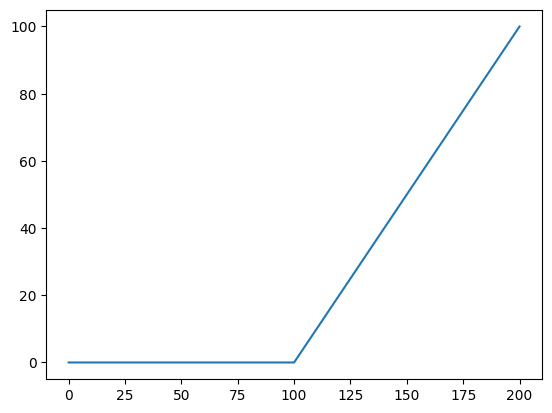

In [2]:
def Call(S, K):
    return np.maximum(S-K, 0)

def Put(S, K):
    return np.maximum(K-S, 0)

#Exemplo:
S = np.linspace(0,200,21); K=100
py.plot(S,Call(S,K))
py.show

## Versão 0 do método

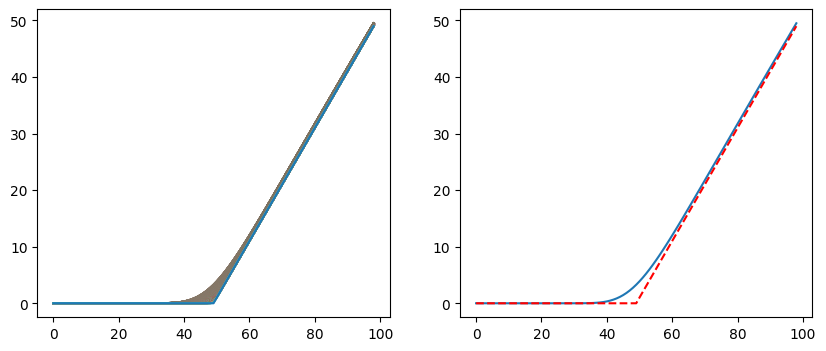

B&S:  3.8826838282197933
Dif_fin:  3.8773980379738733
CRR:  3.882911274589988


In [ ]:
def difFin0(vol, r, payoff, K, T, N_S, N_t):

    # define parâmetros
    dS = 2 * K / N_S
    dt = T / N_t

    # cria vetor e matriz
    S = np.arange(N_S+1) * dS
    V = np.zeros((N_S+1, N_t+1))

    # payoff
    V[:, N_t] = payoff(S, K)

    # involution
    for n in range(N_t, 0, -1):
        for i in range(1, N_S):
            Delta = (V[i+1, n] - V[i-1, n]) / (2 * dS)
            Gamma = (V[i+1, n] - 2*V[i, n] + V[i-1, n]) / dS**2
            Theta = -0.5 * vol**2 * S[i]**2 * Gamma - r * S[i] * Delta + r*V[i, n]
            V[i, n-1] = V[i, n] - dt * Theta
        V[0, n-1]   = 2 * V[1, n] - V[2, n]
        V[N_S, n-1] = 2 * V[N_S-1, n] - V[N_S-2, n]

    return (V, S)

#Exemplo
K=49; vol=0.3; r=0.06; T=3/12; N_S=98; N_t=300;
V,S = difFin0(vol, r, Call, K, T, N_S, N_t)
fig, (ax1, ax2) = py.subplots(1, 2,figsize=(10,4))
ax1.plot(S,V)
ax2.plot(S,V[:,0],S,V[:,-1],'r--')
py.show()
#Compara com solução analitica para S0 = 50
S0=50
idx = np.argsort(np.abs(S-S0))[0]
V_price_diff_fin = V[idx,0] #Precisa encontar o índice
opt1_BS = fo.BlackScholesOption(50,K,T,r,r,vol)
V_price_BS = opt1_BS.call()
opt1_CRR = fo.binomial_tree_options.CRRBinomialTreeOption(50,K,T,r,r,vol,'european',N_t)
V_price_CRR = opt1_CRR.call()

print("B&S: ",V_price_BS)
print("Dif_fin: ", V_price_diff_fin)
print("CRR: ",V_price_CRR)


## Versão 1 do método (versão vetorizada do método 1)

In [ ]:
def difFin1(vol, r, payoff, K, T, N_S, N_t):

    # define parâmetros
    dS = 2 * K / N_S
    dt = T / N_t

    # cria vetor e matriz
    S = np.arange(N_S+1) * dS
    V = np.zeros((N_S+1, N_t+1))

    # payoff
    V[:, N_t] = payoff(S, K)

    for n in range(N_t, 0, -1):
        Delta = (V[2:N_S+1, n] - V[0:N_S-1, n]) / (2 * dS)
        Gamma = (V[2:N_S+1, n] - 2*V[1:N_S, n] + V[0:N_S-1, n]) / dS**2
        Theta = -0.5 * vol**2 * S[1:N_S]**2 * Gamma - r * S[1:N_S] * Delta + r*V[1:N_S, n]
        V[1:N_S, n-1] = V[1:N_S, n] - dt * Theta
        V[0, n-1]     = 2 * V[1, n-1] - V[2, n-1]
        V[N_S, n-1]   = 2 * V[N_S-1, n-1] - V[N_S-2, n-1]

    return (V, S)

#Exemplo
K=49; vol=0.3; r=0.06; T=3/12; N_S=98; N_t=300;
V,S = difFin1(vol, r, Call, K, T, N_S, N_t)
fig, (ax1, ax2) = py.subplots(1, 2,figsize=(10,4))
ax1.plot(S,V)
ax2.plot(S,V[:,0],S,V[:,-1],'r--')
py.show()
#Compara com solução analitica para S0 = 50
S0=50
idx = np.argsort(np.abs(S-S0))[0]
V_price_diff_fin = V[idx,0] #Precisa encontar o índice
opt1_BS = fo.BlackScholesOption(50,K,T,r,r,vol)
V_price_BS = opt1_BS.call()
opt1_CRR = fo.binomial_tree_options.CRRBinomialTreeOption(50,K,T,r,r,vol,'european',N_t)
V_price_CRR = opt1_CRR.call()

print("B&S: ",V_price_BS)
print("Dif_fin: ", V_price_diff_fin)
print("CRR: ",V_price_CRR)

## Versão 2 do método

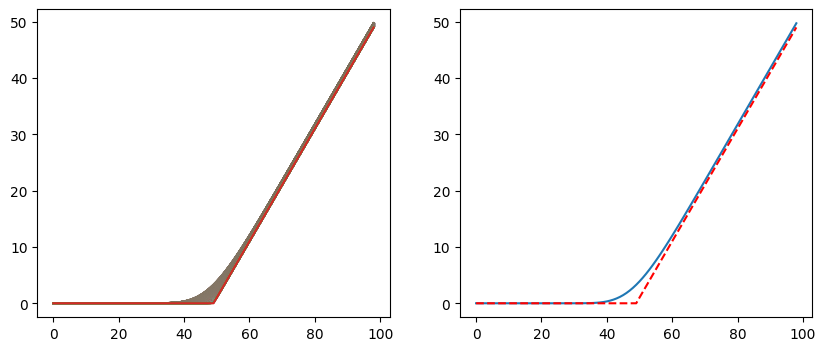

B&S:  3.8826838282197933
Dif_fin:  3.880372592258752
CRR:  3.882911274589988


In [4]:
def difFin2(vol, r, payoff, K, T, N_S):
    # define parâmetros
    dS = 2 * K / N_S
    dt = 0.5 / (vol ** 2 * N_S**2 + r)
    N_t = np.ceil(T/dt).astype(int)

    # cria vetor e matriz
    S = np.arange(N_S+1) * dS
    V = np.zeros((N_S+1, N_t+1))

    # payoff
    V[:, N_t] = payoff(S, K)

    for n in range(N_t, 0, -1):
        Delta = (V[2:N_S+1, n] - V[0:N_S-1, n]) / (2 * dS)
        Gamma = (V[2:N_S+1, n] - 2*V[1:N_S, n] + V[0:N_S-1, n]) / dS**2
        Theta = -0.5 * vol**2 * S[1:N_S]**2 * Gamma - r * S[1:N_S] * Delta + r*V[1:N_S, n]
        
        V[1:N_S, n-1] = V[1:N_S, n] - dt * Theta
        
        V[0, n-1]     = 2 * V[1, n-1] - V[2, n-1]
        V[N_S, n-1]   = 2 * V[N_S-1, n-1] - V[N_S-2, n-1]

    return (V, S)

#Exemplo
K=49; vol=0.3; r=0.06; T=3/12; N_S=98;
V,S = difFin2(vol, r, Call, K, T, N_S)
fig, (ax1, ax2) = py.subplots(1, 2,figsize=(10,4))
ax1.plot(S,V)
ax2.plot(S,V[:,0],S,V[:,-1],'r--')
py.show()
#Compara com solução analitica para S ~ S0
S0=50
idx = np.argsort(np.abs(S-S0))[0]
V_price_diff_fin = V[idx,0] #Precisa encontar o índice
opt1_BS = fo.BlackScholesOption(50,K,T,r,r,vol)
V_price_BS = opt1_BS.call()
opt1_CRR = fo.binomial_tree_options.CRRBinomialTreeOption(50,K,T,r,r,vol,'european',300)
V_price_CRR = opt1_CRR.call()

print("B&S: ",V_price_BS)
print("Dif_fin: ", V_price_diff_fin)
print("CRR: ",V_price_CRR)

## Exemplo de opção com barreira tipo down and out
Para que a opção fique ativa, o ativo subjacente não deve descer abaixo de um valor definido.

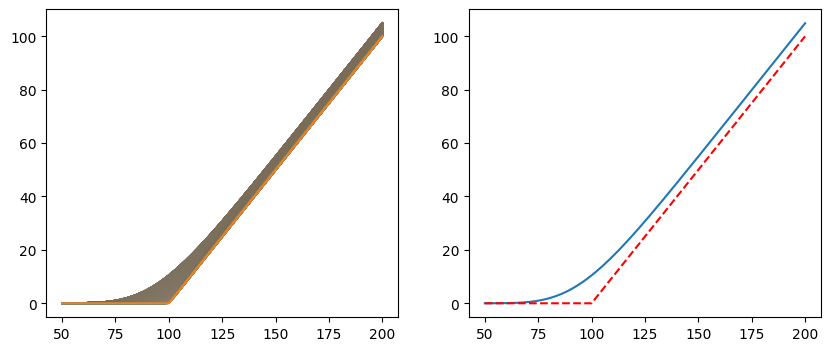

Dif_fin:  10.45190288744326


In [5]:
def difFinBarDownOut(vol, r, payoff, K, T, N_S, barreira):
    # define parâmetros
    dS = (2 * K - barreira) / N_S
    dt = 0.5 / (vol ** 2 * N_S**2 + r)
    N_t = np.ceil(T/dt).astype(int)

    # cria vetor e matriz
    S = np.arange(N_S+1) * dS + barreira
    V = np.zeros ((N_S+1, N_t+1))

    # payoff
    V[:, N_t] = payoff(S, K)

    for n in range(N_t, 0, -1):
        Delta = (V[2:N_S+1, n] - V[0:N_S-1, n]) / (2 * dS)
        Gamma = (V[2:N_S+1, n] - 2*V[1:N_S, n] + V[0:N_S-1, n]) / dS**2
        Theta = -0.5 * vol**2 * S[1:N_S]**2 * Gamma - r * S[1:N_S] * Delta + r*V[1:N_S, n]
        V[1:N_S, n-1] = V[1:N_S, n] - dt * Theta
        V[0, n-1]     = 0 #barreira down and out
        V[N_S, n-1]   = 2 * V[N_S-1, n-1] - V[N_S-2, n-1]

    return (V, S)

#Exemplo
K=100; vol=0.2; r=0.05; T=1; N_S=150; barreira=50
V,S = difFinBarDownOut(vol, r, Call, K, T, N_S, barreira)
fig, (ax1, ax2) = py.subplots(1, 2,figsize=(10,4))
ax1.plot(S,V)
ax2.plot(S,V[:,0],S,V[:,-1],'r--')
py.show()
#Compara com solução analitica para S ~ S0
S0=100
idx = np.argsort(np.abs(S-S0))[0]
V_price_diff_fin = V[idx,0] #Precisa encontar o índice
print("Dif_fin: ", V_price_diff_fin)

##Opções Americanas

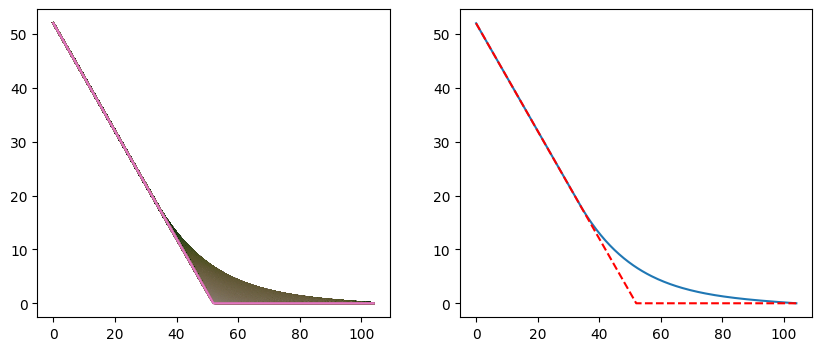

Dif_fin:  7.469766838943496
CRR:  7.477208328936235
BAW:  7.496568454380279


In [ ]:
def difFinAmericana(vol, r, payoff, K, T, N_S):
    dS = 2 * K / N_S
    dt = 0.5 / (vol ** 2 * N_S**2 + r)
    N_t = np.ceil(T/dt).astype(int)

    # cria vetor e matriz
    S = np.arange(N_S+1) * dS
    V = np.zeros ((N_S+1, N_t+1))


    # payoff
    V[:, N_t] = payoff(S, K)

    for n in range(N_t, 0, -1):
        Delta = (V[2:N_S+1, n] - V[0:N_S-1, n]) / (2 * dS)
        Gamma = (V[2:N_S+1, n] - 2*V[1:N_S, n] + V[0:N_S-1, n]) / dS**2
        Theta = -0.5 * vol**2 * S[1:N_S]**2 * Gamma - r * S[1:N_S] * Delta + r*V[1:N_S, n]
        V[1:N_S, n-1] = V[1:N_S, n] - dt * Theta
        V[0, n-1]     = 2 * V[1, n-1] - V[2, n-1]
        V[N_S, n-1]   = 2 * V[N_S-1, n-1] - V[N_S-2, n-1]
        # Modificação para Opção Americana
        V[:, n-1] = np.maximum(V[:, n-1], payoff(S, K))
    return (V, S)

#Exemplo
K=52; vol=0.3; r=0.05; T=2; N_S=208
V,S = difFinAmericana(vol, r, Put, K, T, N_S)
fig, (ax1, ax2) = py.subplots(1, 2,figsize=(10,4))
ax1.plot(S,V)
ax2.plot(S,V[:,0],S,V[:,-1],'r--')
py.show()
#Compara com solução analitica para S ~ S0
S0=50
idx = np.argsort(np.abs(S-S0))[0]
V_price_diff_fin = V[idx,0] #Precisa encontar o índice
opt1_CRR = fo.binomial_tree_options.CRRBinomialTreeOption(50,K,T,r,r,vol,'american',200)
V_price_CRR = opt1_CRR.put()
opt2_BAW = fo.basic_american_options.BAWAmericanApproxOption(S0, K, T, r, r, vol)
V_price_BAW = opt2_BAW.put()
print("Dif_fin: ", V_price_diff_fin)
print("CRR: ",V_price_CRR)
print("BAW: ",V_price_BAW)
